In [2]:
print("shree ram")

shree ram


In [3]:

import tensorflow as tf
print(tf.__version__)

2.10.0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers,models

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

from pathlib import Path
import os.path
import random

import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')


from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [5]:
import urllib.request

url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'
filename = 'helper_functions.py'

urllib.request.urlretrieve(url, filename)

('helper_functions.py', <http.client.HTTPMessage at 0x23c43ebed40>)

In [6]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [7]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [8]:

dataset = "C:/Minor Project-Research 1/bone fracture/mammals"
walk_through_dir(dataset);

There are 52 directories and 1 images in 'C:/Minor Project-Research 1/bone fracture/mammals'.
There are 0 directories and 0 images in 'C:/Minor Project-Research 1/bone fracture/mammals\.ipynb_checkpoints'.
There are 0 directories and 347 images in 'C:/Minor Project-Research 1/bone fracture/mammals\african_elephant'.
There are 0 directories and 333 images in 'C:/Minor Project-Research 1/bone fracture/mammals\alpaca'.
There are 0 directories and 343 images in 'C:/Minor Project-Research 1/bone fracture/mammals\american_bison'.
There are 0 directories and 299 images in 'C:/Minor Project-Research 1/bone fracture/mammals\anteater'.
There are 0 directories and 315 images in 'C:/Minor Project-Research 1/bone fracture/mammals\arctic_fox'.
There are 0 directories and 331 images in 'C:/Minor Project-Research 1/bone fracture/mammals\armadillo'.
There are 0 directories and 330 images in 'C:/Minor Project-Research 1/bone fracture/mammals\baboon'.
There are 0 directories and 310 images in 'C:/Minor P

In [9]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

C:\Users\AJEEB SAGAR\AppData\Local\Temp\ipykernel_21232\994582165.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


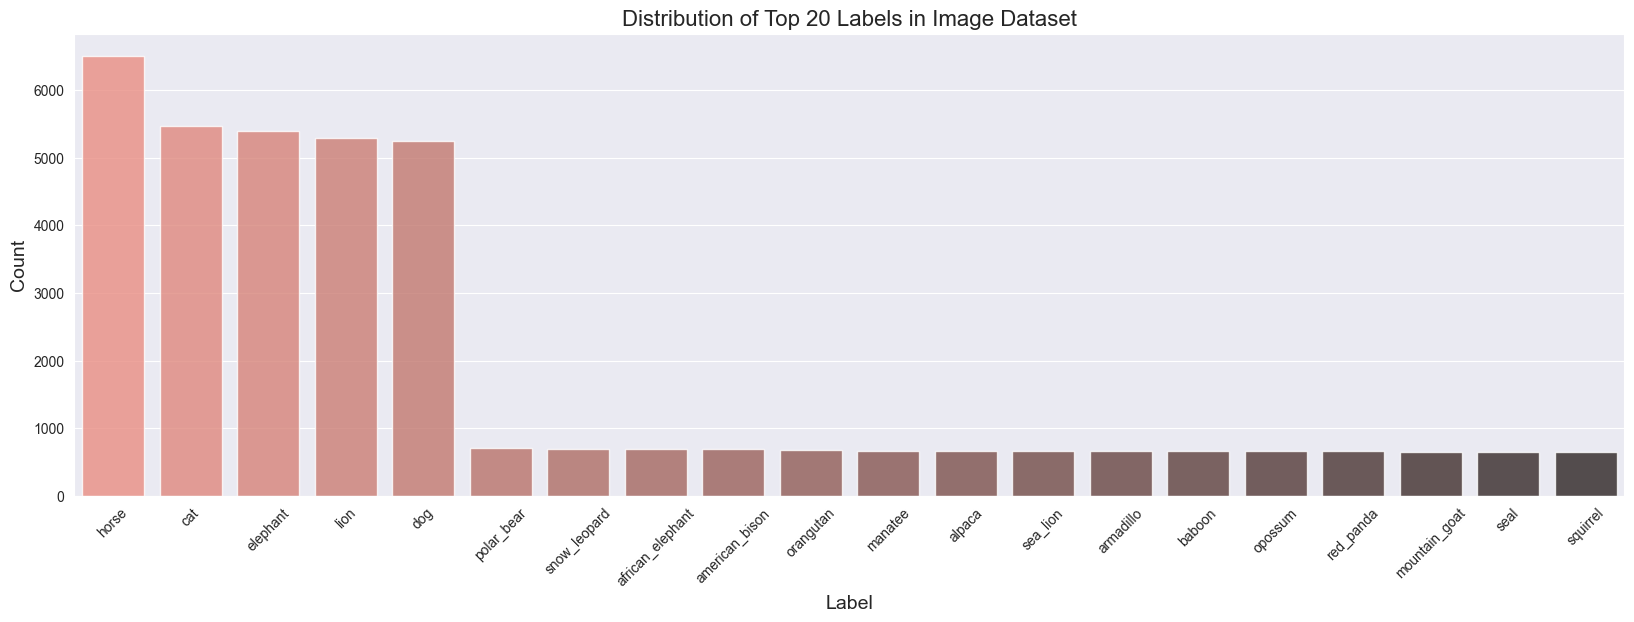

In [10]:
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

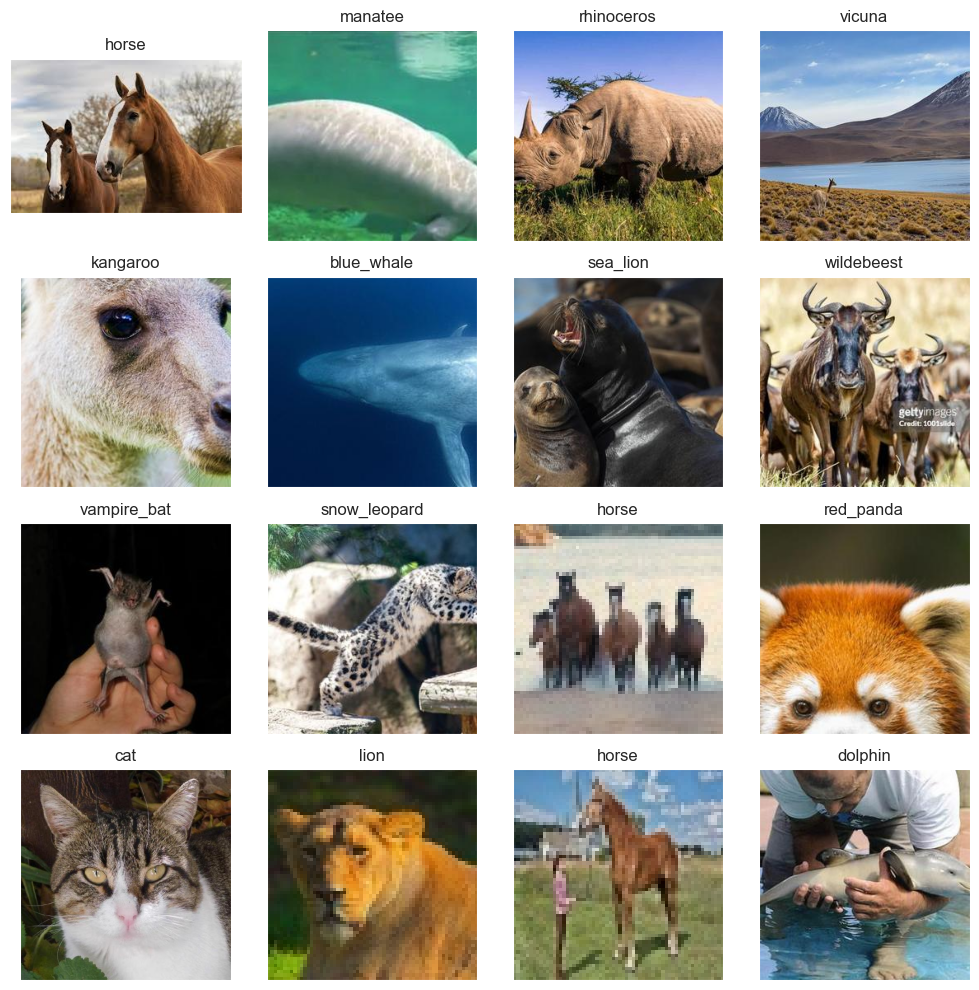

In [11]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [12]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

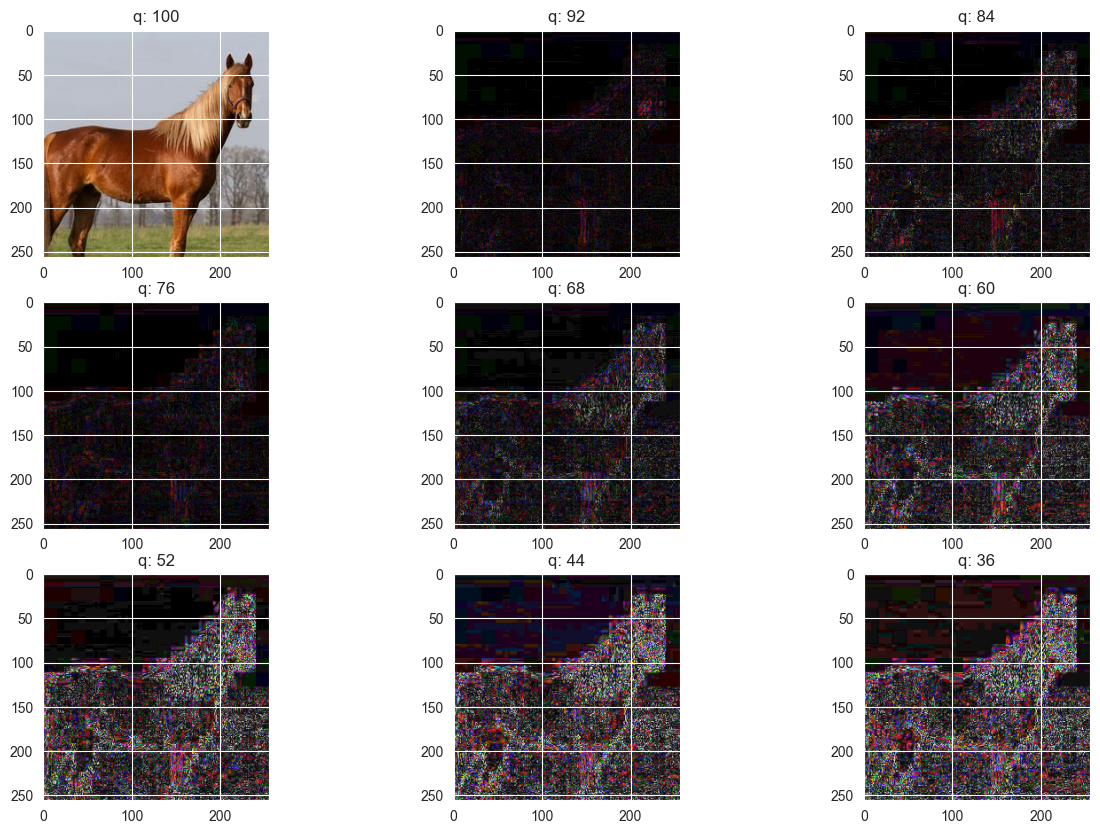

In [13]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Set the directory containing images
dir_path = 'C:\Minor Project-Research 1/bone fracture\horse'
image_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(('.jpg', '.png'))]

# Choose a random image path
p = random.choice(image_files)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0

# ELA parameters
init_val = 100
columns = 3
rows = 3

# Plotting
fig = plt.figure(figsize=(15, 10))
for i in range(1, columns * rows + 1):
    quality = init_val - (i - 1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()


In [14]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)



train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)


# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    # Use 'validation_split' instead of 'subset'
    # and specify a percentage, e.g., 0.2 for 20% validation data
    subset='training'  # Use 'subset' for training data
)

# Get the validation generator from the train generator by specifying subset='validation'
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle validation data
    seed=42,
    subset='validation'  # Use 'subset' for validation data
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 34732 validated image filenames belonging to 49 classes.
Found 8682 validated image filenames belonging to 49 classes.
Found 10854 validated image filenames belonging to 49 classes.


In [15]:
import tensorflow as tf
from tensorflow.keras import layers

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


 #Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False




In [16]:

# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint.weights.h5" # Add .weights.h5 extension
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [17]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [18]:
!nvidia-smi

Fri Dec 13 00:04:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P0             11W /   75W |    1835MiB /   4096MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


# Change the output layer to have 49 units instead of 525
outputs = Dense(49, activation='softmax')(x) # Assuming you have 49 classes in your target

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=150,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "animals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/animals_classification/20241213-000447
Epoch 1/150
1086/1086 [==============================] - 108s 93ms/step - loss: 2.6395 - accuracy: 0.3763 - val_loss: 1.3460 - val_accuracy: 0.6708 - lr: 1.0000e-04
Epoch 2/150
1086/1086 [==============================] - 97s 89ms/step - loss: 1.4612 - accuracy: 0.6132 - val_loss: 0.6452 - val_accuracy: 0.8307 - lr: 1.0000e-04
Epoch 3/150
  96/1086 [=>............................] - ETA: 1:08 - loss: 1.1460 - accuracy: 0.6865

In [65]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.08777
Test Accuracy: 97.75%


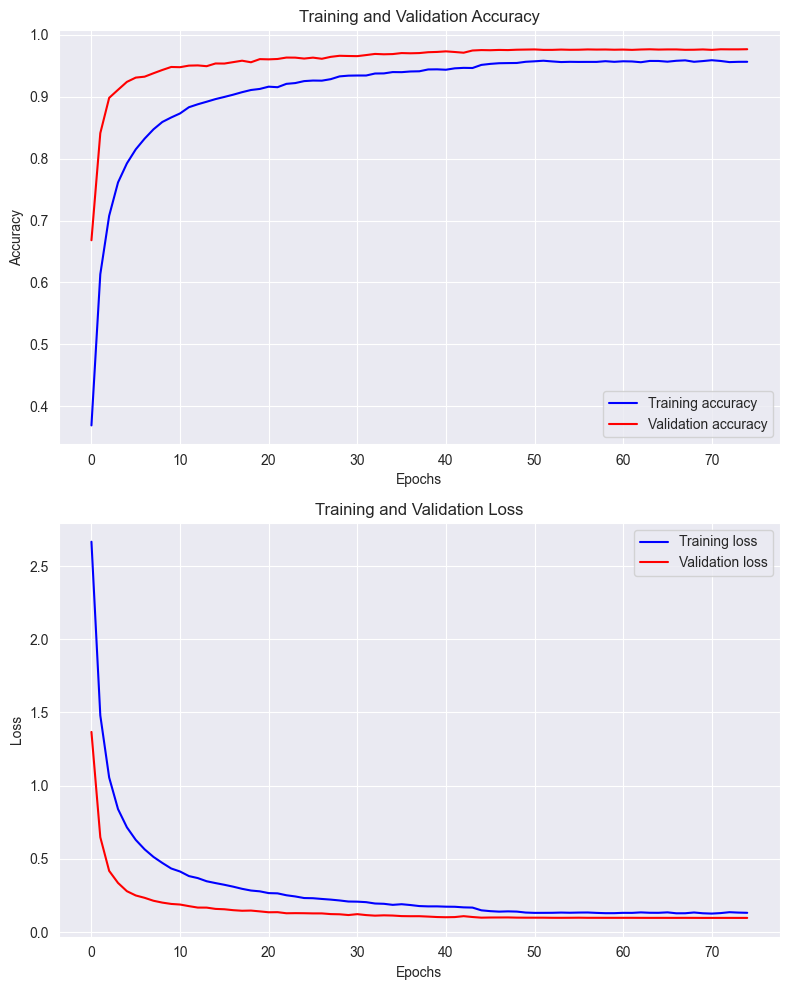

In [66]:
import matplotlib.pyplot as plt

# Check if `history` contains the expected keys
if 'accuracy' in history.history and 'val_accuracy' in history.history and 'loss' in history.history and 'val_loss' in history.history:
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    plt.figure(figsize=(8, 10))

    # Plot training and validation accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add grid lines

    # Plot training and validation loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add grid lines

    plt.tight_layout()
    plt.show()
else:
    print("Error: `history` object does not contain required keys.")


In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

NameError: name 'model' is not defined

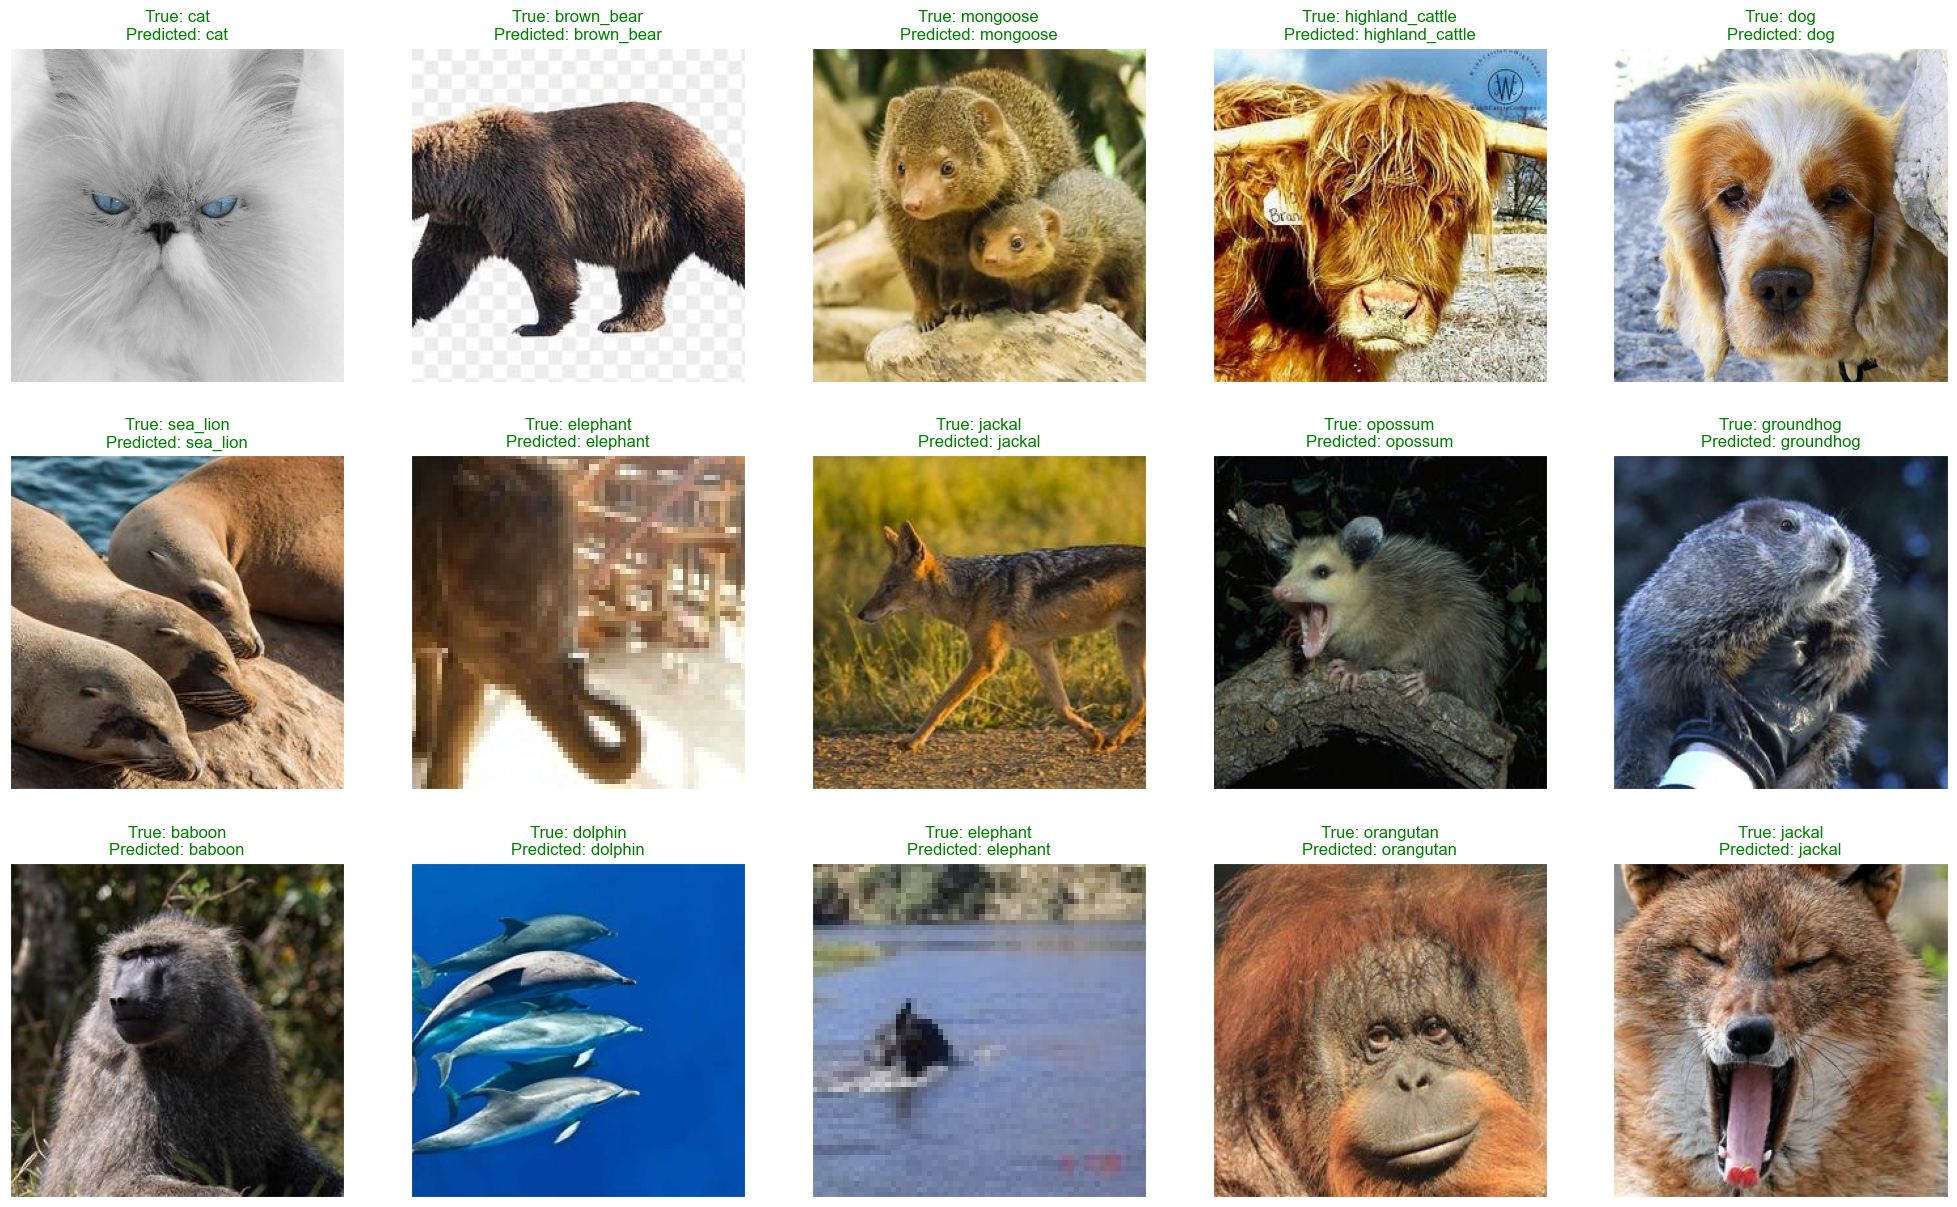

<Figure size 640x480 with 0 Axes>

In [85]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [86]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                  precision    recall  f1-score   support

african_elephant       0.88      0.90      0.89       133
          alpaca       0.99      0.98      0.98       142
  american_bison       1.00      0.99      1.00       127
        anteater       0.97      0.99      0.98       110
      arctic_fox       1.00      0.95      0.97       128
       armadillo       0.99      0.98      0.99       133
          baboon       0.98      0.98      0.98       131
          badger       0.99      0.95      0.97       124
      blue_whale       0.99      0.98      0.98        93
      brown_bear       0.99      0.97      0.98       138
           camel       0.95      0.98      0.97       102
             cat       1.00      1.00      1.00      1120
             dog       1.00      1.00      1.00      1085
         dolphin       0.98      0.98      0.98       129
        elephant       0.95      0.96      0.95      1027
         giraffe       0.99      0.98      0.99       143
       ground

In [87]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
african_elephant   0.875912  0.902256  0.888889    133.00000
alpaca             0.985816  0.978873  0.982332    142.00000
american_bison     1.000000  0.992126  0.996047    127.00000
anteater           0.973214  0.990909  0.981982    110.00000
arctic_fox         1.000000  0.945312  0.971888    128.00000
armadillo          0.992424  0.984962  0.988679    133.00000
baboon             0.984733  0.984733  0.984733    131.00000
badger             0.991597  0.951613  0.971193    124.00000
blue_whale         0.989130  0.978495  0.983784     93.00000
brown_bear         0.985294  0.971014  0.978102    138.00000
camel              0.952381  0.980392  0.966184    102.00000
cat                1.000000  1.000000  1.000000   1120.00000
dog                0.997243  1.000000  0.998619   1085.00000
dolphin            0.984375  0.976744  0.980545    129.00000
elephant           0.945507  0.962999  0.954173   1027.00000
giraffe            0.992908  0.979021  0.985915    143.00000
groundhog          0.965517  0.982456  0.973913    114.00000
highland_cattle    0.984000  0.968504  0.976190    127.00000
horse              0.983871  0.972665  0.978236   1317.00000
jackal             0.941748  0.989796  0.965174     98.00000
kangaroo           0.985185  0.970803  0.977941    137.00000
koala              0.981982  1.000000  0.990909    109.00000
lion               0.975769  0.968548  0.972145   1081.00000
manatee            0.985401  0.978261  0.981818    138.00000
mongoose           0.970874  0.952381  0.961538    105.00000
mountain_goat      1.000000  0.977612  0.988679    134.00000
opossum            0.977444  0.992366  0.984848    131.00000
orangutan          1.000000  1.000000  1.000000    117.00000
otter              0.942529  1.000000  0.970414     82.00000
polar_bear         0.965278  0.972028  0.968641    143.00000
porcupine          0.984496  1.000000  0.992188    127.00000
red_panda          0.992366  0.984848  0.988593    132.00000
rhinoceros         0.966102  0.991304  0.978541    115.00000
sea_lion           0.924138  0.924138  0.924138    145.00000
seal               0.916667  0.887097  0.901639    124.00000
snow_leopard       0.992366  1.000000  0.996169    130.00000
squirrel           0.992593  0.964029  0.978102    139.00000
sugar_glider       0.977273  0.977273  0.977273     88.00000
tapir              0.991870  0.976000  0.983871    125.00000
vampire_bat        0.946237  0.977778  0.961749     90.00000
vicuna             0.965517  0.943820  0.954545     89.00000
walrus             0.965517  0.991150  0.978166    113.00000
warthog            0.979381  0.989583  0.984456     96.00000
water_buffalo      0.958904  0.985915  0.972222     71.00000
weasel             0.965517  0.982456  0.973913    114.00000
wildebeest         0.974138  0.949580  0.961702    119.00000
wombat             0.977612  0.984962  0.981273    133.00000
yak                0.957447  0.978261  0.967742     92.00000
zebra              0.982759  1.000000  0.991304    114.00000
accuracy           0.977520  0.977520  0.977520      0.97752
macro avg          0.973899  0.975369  0.974512  10854.00000
weighted avg       0.977702  0.977520  0.977539  10854.00000

In [89]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array) # Using grad_model here
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # ... (rest of your function) # Assign class_channel here
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # ... (rest of the function)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
  
    superimposed_img.save(cam_path)

 
    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

C:\Users\AJEEB SAGAR\AppData\Local\Temp\ipykernel_12624\1371114228.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


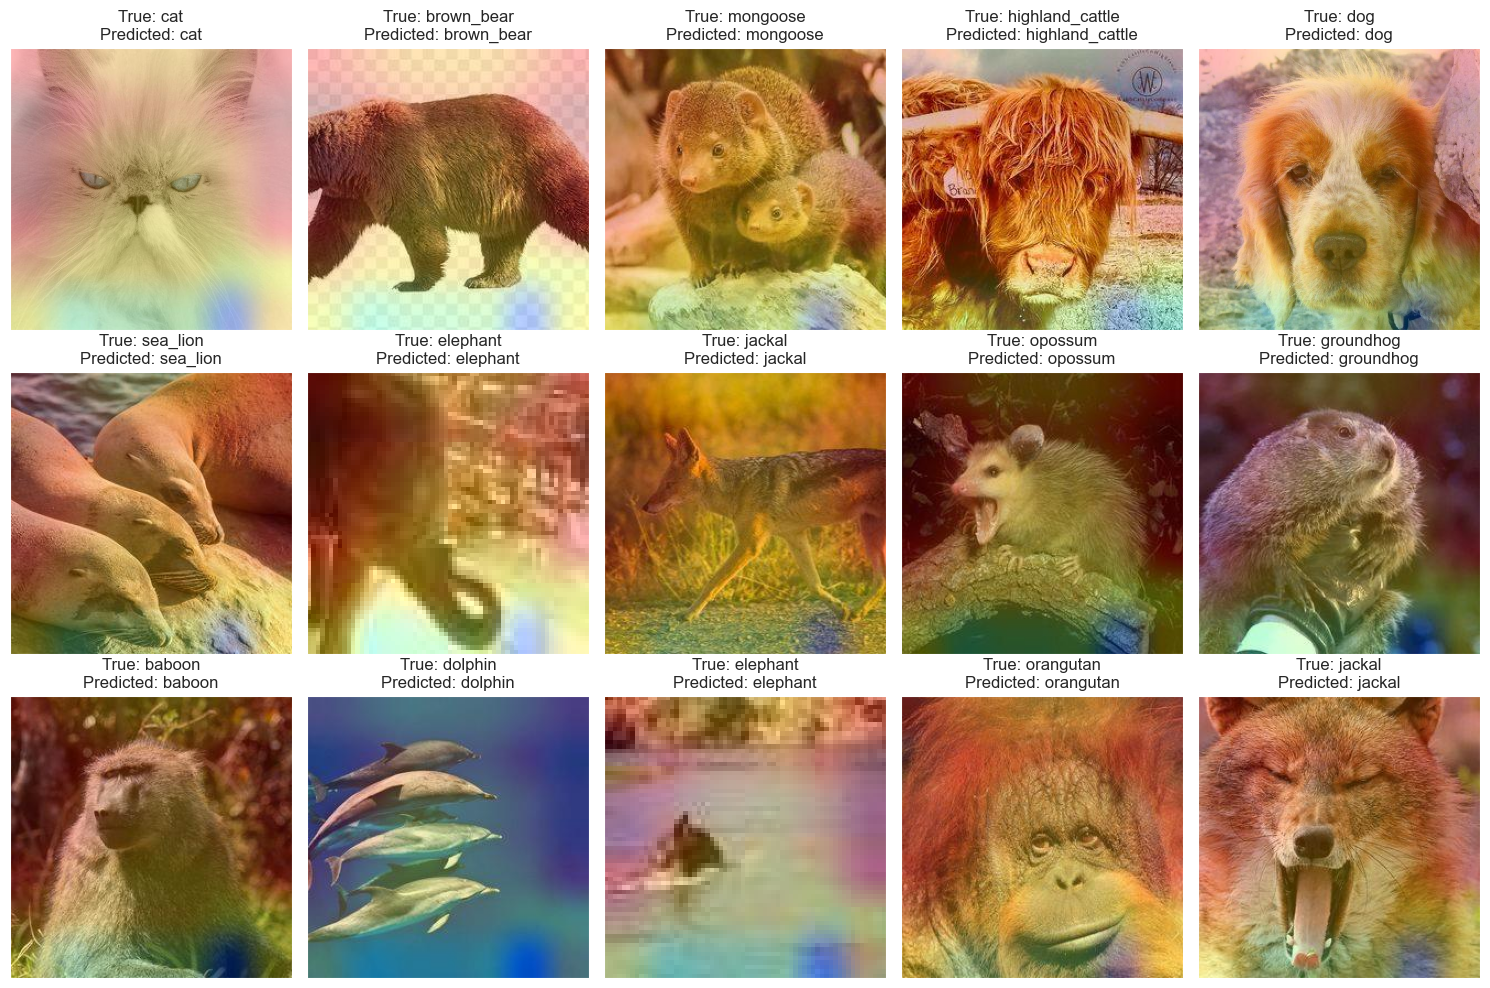

In [90]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()